In [1]:
import numpy as np
import pandas as pd
import torch
import os

In [2]:
import sys
sys.path.append('..')
from src.utils import (calculate_bs, fix_predictions, fix_brier_scores)
from src.data.dataset import SurvivalDataset

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pyreadr

rda_file_path = '../data/raw/pbc.rda'
data = pyreadr.read_r(rda_file_path)['pbc']
data.head()

,id,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
0,1,400,2,1,58.765229,f,1,1,1,1.0,14.5,261,2.60,156,1718.0,137.95,172,190,12.2,4
1,2,4500,0,1,56.446270,f,0,1,1,0.0,1.1,302,4.14,54,7394.8,113.52,88,221,10.6,3
2,3,1012,2,1,70.072553,m,0,0,0,0.5,1.4,176,3.48,210,516.0,96.10,55,151,12.0,4
3,4,1925,2,1,54.740589,f,0,1,1,0.5,1.8,244,2.54,64,6121.8,60.63,92,183,10.3,4
4,5,1504,1,2,38.105407,f,0,1,1,0.0,3.4,279,3.53,143,671.0,113.15,72,136,10.9,3


In [5]:
data = SurvivalDataset(fname='pbc.rda')

In [6]:
data.preprocess().head()

,time,status,age,edema,bili,albumin,alk.phos,ast,protime,trt_1,...,platelet_514,platelet_517,platelet_518,platelet_539,platelet_563,platelet_721,stage_1,stage_2,stage_3,stage_4
0,400,1,0.768941,3.553818,2.562152,-2.114296,-0.143350,0.314753,1.441846,1,...,0,0,0,0,0,0,0,0,0,1
1,4500,0,0.546706,-0.396969,-0.481759,1.513818,2.931464,-0.184766,-0.129360,1,...,0,0,0,0,0,0,0,0,1,0
2,1012,1,1.852567,1.578425,-0.413611,-0.041088,-0.794408,-0.540952,1.245445,1,...,0,0,0,0,0,0,0,0,0,1
3,1925,1,0.383244,1.578425,-0.322748,-2.255651,2.241950,-1.266205,-0.423961,1,...,0,0,0,0,0,0,0,0,0,1
4,1504,0,-1.210972,-0.396969,0.040704,0.076708,-0.710453,-0.192331,0.165241,0,...,0,0,0,0,0,0,0,0,1,0


In [7]:
class BrierScore():
  def __init__(self, data, end_time_point):
    from lifelines import CoxPHFitter
    self.data = data
    censoring_model = CoxPHFitter()
    censoring_model.fit(self.data, 'time', event_col='status', show_progress=True)
    self.censoring_weights = 1 / censoring_model.predict_partial_hazard(self.data)
    self.end_time_point = end_time_point

  def brier_score_pysurvival(self, pysurv_model, X_test, T_test, E_test):
    from pysurvival.utils.metrics import brier_score
    example_bs = brier_score(pysurv_model, X_test, T_test, E_test, t_max=None)
    transformed_bs = fix_brier_scores(np.array(example_bs[1]), pysurv_model.times, self.end_time_point)
    return transformed_bs
    

  def brier_score_vspyct():
    pass

In [8]:
data.preprocess()
bs = BrierScore(data.preprocessed)
bs.censoring_weights

/Users/viktorandonovic/miniconda3/lib/python3.8/site-packages/lifelines/utils/__init__.py:992: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
/Users/viktorandonovic/miniconda3/lib/python3.8/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column chol_1000 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['status'].astype(bool)
>>> print(df.loc[events, 'chol_1000'].var())
>>> print(df.loc[~events, 'chol_1000'].var())

A very low variance means that the column chol_1000 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), Convergenc

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

In [11]:
X_train, T_train, E_train, X_test, T_test, E_test = data.pysurvival_split()

In [12]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel

rsf = RandomSurvivalForestModel(num_trees=50)
rsf.fit(X_train, T_train, E_train, max_features="sqrt", max_depth=5)

RandomSurvivalForestModel

In [13]:
predicted_rsf = rsf.predict_survival(X_test)
transformed_predictions_rsf = fix_predictions(predicted_rsf, rsf.times, int(T_train.max()))

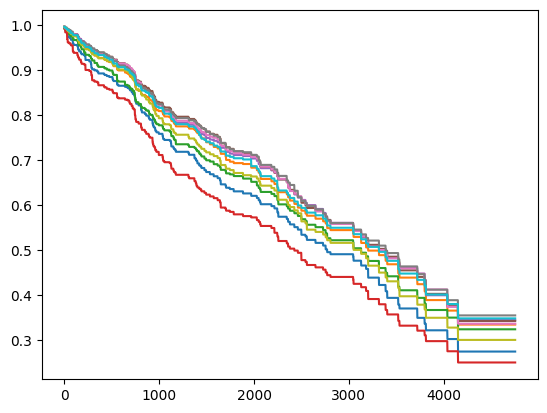

In [14]:
for i in range(10):
  plt.plot(transformed_predictions_rsf[i][41:])

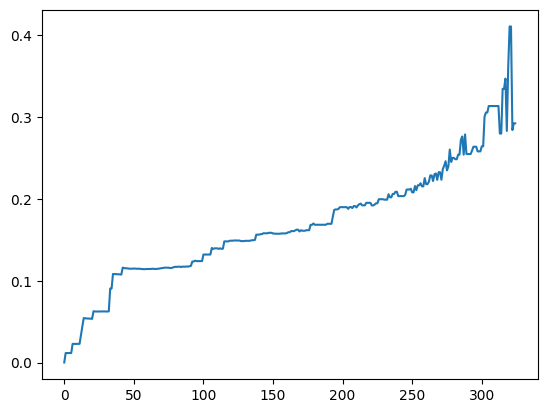

In [15]:
from pysurvival.utils.metrics import brier_score
example_bs = brier_score(rsf, X_test, T_test, E_test, t_max=None)
plt.plot(example_bs[1])

In [19]:
transformed_bs = fix_brier_scores(np.array(example_bs[1]), example_bs[0], int(T_train.max()))

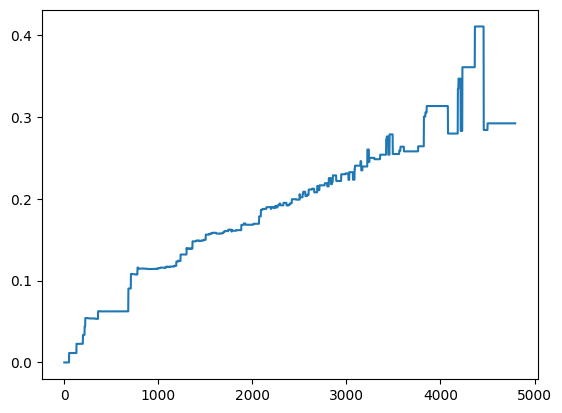

In [20]:
plt.plot(transformed_bs)

In [38]:
transformed_predictions_rsf.shape, y_test.shape

((84, 4795), torch.Size([84, 4795]))

In [36]:
X_train, X_test, y_train, y_test = data.get_tensors()

Succesfully created time tensor of shape: torch.Size([418, 4795])
(334, 769) torch.Size([334, 4795])


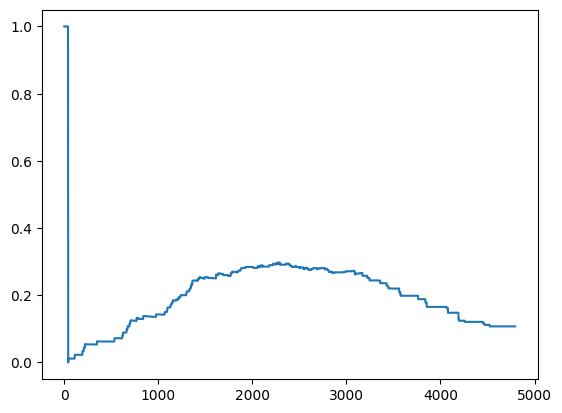

In [52]:
((torch.tensor(transformed_predictions_rsf) - y_test)**2)

In [54]:
# STEPS
# 1) nafitaj null cox model.
# 2) sekojpat koga evaluiras, vo sekoj od test primerite: prediktni gi survival vrednostite od momentot na cenzuriranje pa nataka koristejki go null cox modelot
# 3) izracunaj censoring weights (proveri kako se racunaat) i napravi korekcija na brier score-ot

# regarding censoring weights:
# ima formula kako se racunaat, vidi paperot vo safari, glavno e da imas null cox model i ostanatoto e slicing niz vektorite i primenuvanje na formulata